In [1]:
import os
import torch
import torch.nn as nn

from profiler import Profiler
from nas.models.with_mobilenet import PoseEstimationWithMobileNet
from mobilenetv2 import MobileNetV2
from ptflops import get_model_complexity_info


In [4]:
device = torch.device("cpu")
if device.type != "cpu":
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
mnv1 = PoseEstimationWithMobileNet().to(device)

mnv1 backbone cpu
+------+----------+---------+------------+
| Name | Mean, ms | Std, ms | Percent, % |
+------+----------+---------+------------+
|  0   |   5.22   |   0.47  |    4.89    |
|  1   |  13.12   |   1.54  |    12.3    |
|  2   |   8.09   |   0.89  |    7.59    |
|  3   |   9.46   |   1.24  |    8.87    |
|  4   |   3.65   |   0.52  |    3.42    |
|  5   |   5.16   |   0.73  |    4.84    |
|  6   |   7.36   |   1.03  |    6.9     |
|  7   |  10.92   |   1.22  |   10.24    |
|  8   |   10.9   |   1.21  |   10.22    |
|  9   |  10.77   |   0.99  |    10.1    |
|  10  |  10.93   |   1.21  |   10.24    |
|  11  |  11.08   |   1.84  |   10.39    |
+------+----------+---------+------------+
Total time: 106.65 ms, 	std: 7.36 ms


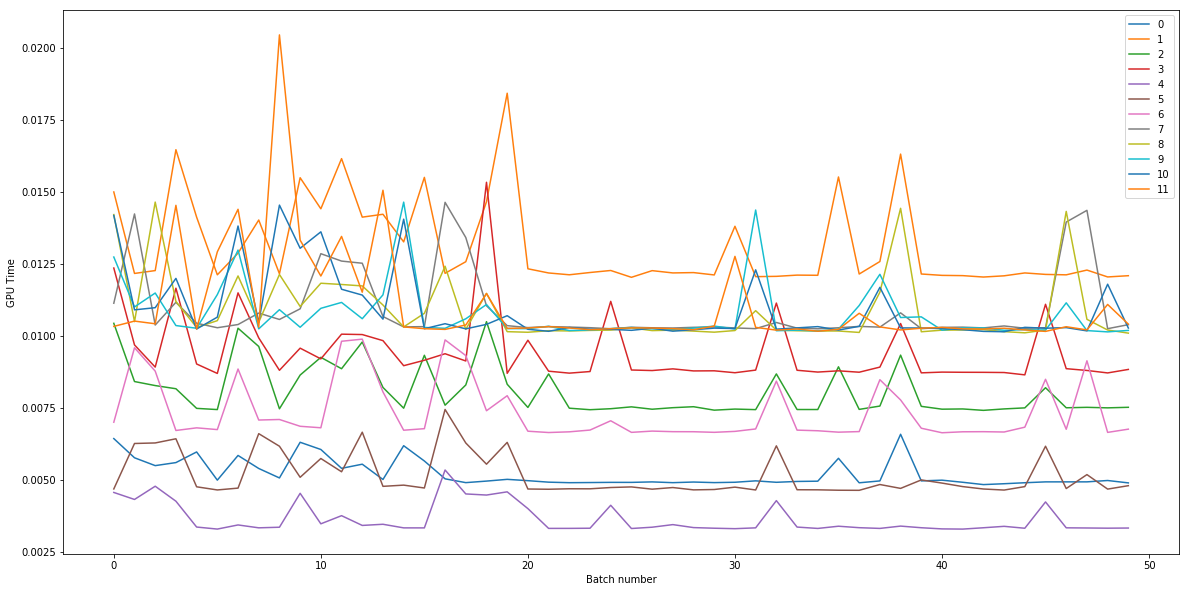

In [48]:
profiler = Profiler(mnv1.model, f"mnv1 backbone {device.type}")
a = torch.randn((4, 3, 128, 128)).to(device)
for _ in range(50):
    profiler.forward(a)
profiler.collect_data()
profiler.show_table()
profiler.plot_results()
total_backbone = profiler.total_time_mean

cpm cpu
+-------+----------+---------+------------+
|  Name | Mean, ms | Std, ms | Percent, % |
+-------+----------+---------+------------+
| align |   1.67   |   0.4   |   15.27    |
| trunk |   6.61   |   1.25  |   60.46    |
|  conv |   2.65   |   0.71  |   24.27    |
+-------+----------+---------+------------+
Total time: 10.93 ms, 	std: 2.05 ms


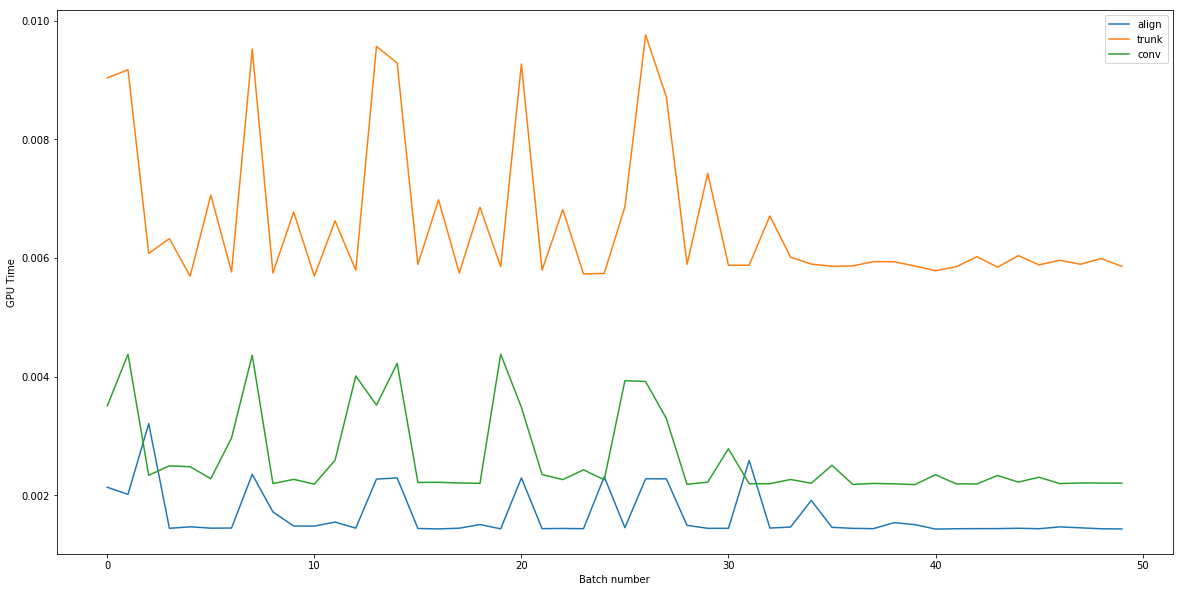

In [51]:
profiler = Profiler(mnv1.cpm, f"cpm {device.type}")
a = torch.randn((4, 512, 16, 16)).to(device)
for _ in range(50):
    profiler.forward(a)
profiler.collect_data()
profiler.show_table()
profiler.plot_results()
total_cpm = profiler.total_time_mean

initial_stage cpu
+----------+----------+---------+------------+
|   Name   | Mean, ms | Std, ms | Percent, % |
+----------+----------+---------+------------+
|  trunk   |   8.56   |   2.11  |   57.51    |
| heatmaps |   3.15   |   0.61  |   21.19    |
|   pafs   |   3.17   |   0.59  |    21.3    |
+----------+----------+---------+------------+
Total time: 14.88 ms, 	std: 2.95 ms


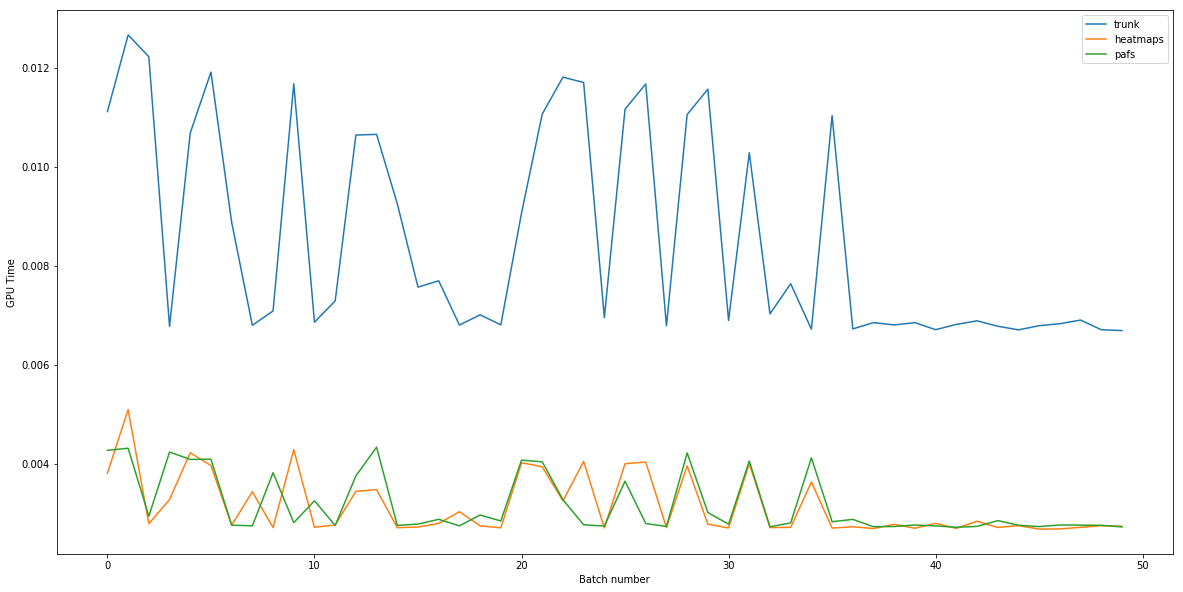

In [57]:
profiler = Profiler(mnv1.initial_stage, f"initial_stage {device.type}")
a = torch.randn((4, 128, 16, 16)).to(device)
for _ in range(50):
    profiler.forward(a)
profiler.collect_data()
profiler.show_table()
profiler.plot_results()
total_init_stage = profiler.total_time_mean

refinement stage cpu
+----------+----------+---------+------------+
|   Name   | Mean, ms | Std, ms | Percent, % |
+----------+----------+---------+------------+
|  trunk   |  28.11   |   4.65  |   95.95    |
| heatmaps |   0.61   |   0.14  |    2.09    |
|   pafs   |   0.57   |   0.16  |    1.96    |
+----------+----------+---------+------------+
Total time: 29.30 ms, 	std: 4.86 ms


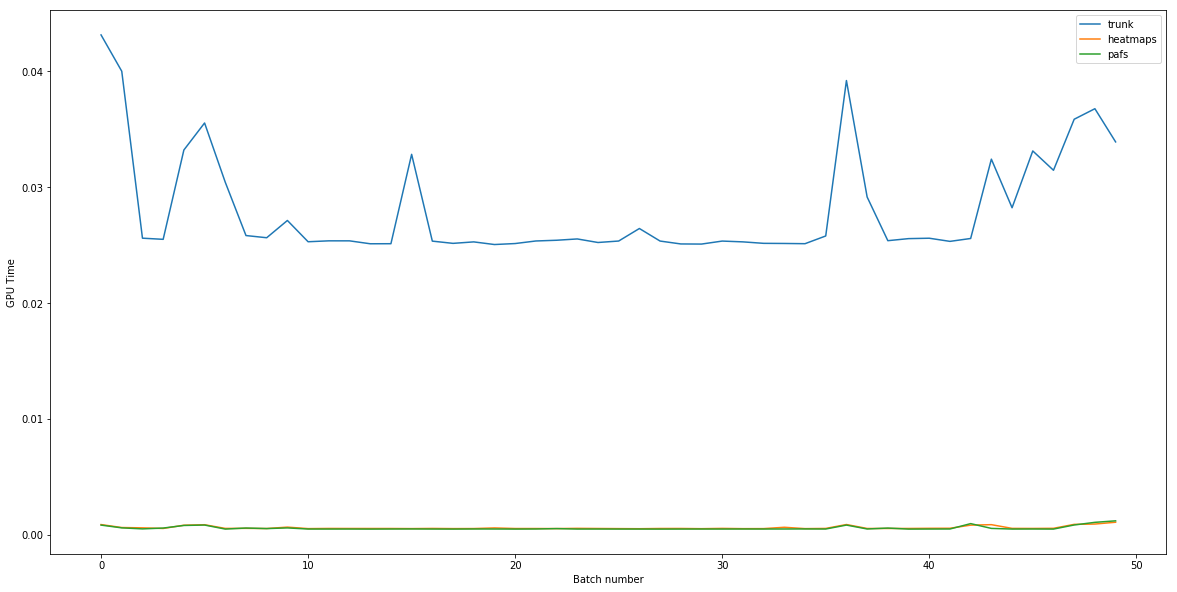

In [59]:
profiler = Profiler(mnv1.refinement_stages._modules["0"], f"refinement stage {device.type}")
a = torch.randn((4, 185, 16, 16)).to(device)
for _ in range(50):
    profiler.forward(a)
profiler.collect_data()
profiler.show_table()
profiler.plot_results()
total_refine_stage = profiler.total_time_mean

In [88]:
def info(name, block_time, total_time):
    ratio = block_time / total_time
    return f"{name:<20} total: {block_time * 1000:<8.4f} ms, relative: {ratio:.4f}, percent: {ratio * 100:.4f}%"

total = total_backbone + total_cpm + total_init_stage + total_refine_stage

print(f"{device.type}")
print(info("mnv1 backbone", total_backbone, total))
print(info("cpm", total_cpm, total))
print(info("initial stage", total_init_stage, total))
print(info("refinement stage", total_refine_stage, total))
print(f"Total net time: {total * 1000:.4f} ms")

cpu
mnv1 backbone        total: 106.6484 ms, relative: 0.6593, percent: 65.9310%
cpm                  total: 10.9301  ms, relative: 0.0676, percent: 6.7571%
initial stage        total: 14.8812  ms, relative: 0.0920, percent: 9.1997%
refinement stage     total: 29.2979  ms, relative: 0.1811, percent: 18.1122%
Total net time: 161.7576 ms


In [31]:
macs_bb, params_bb = get_model_complexity_info(mnv1.model, (3, 386, 386))
macs_cpm, params_cpm = get_model_complexity_info(mnv1.cpm, (512, 46, 46))
macs_is, params_is = get_model_complexity_info(mnv1.initial_stage, (128, 46, 46))
macs_rs, params_rs = get_model_complexity_info(mnv1.refinement_stages[0], (185, 46, 46))

Sequential(
  1.613 M, 100.000% Params, 4.209 GMac, 100.000% MACs, 
  (0): Profilable(
    0.001 M, 0.058% Params, 0.036 GMac, 0.849% MACs, 
    (module): Sequential(
      0.001 M, 0.058% Params, 0.036 GMac, 0.849% MACs, 
      (0): Conv2d(0.001 M, 0.054% Params, 0.032 GMac, 0.765% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(0.0 M, 0.004% Params, 0.002 GMac, 0.057% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(0.0 M, 0.000% Params, 0.001 GMac, 0.028% MACs, inplace=True)
    )
  )
  (1): Profilable(
    0.003 M, 0.157% Params, 0.098 GMac, 2.322% MACs, 
    (module): Sequential(
      0.003 M, 0.157% Params, 0.098 GMac, 2.322% MACs, 
      (0): Conv2d(0.0 M, 0.018% Params, 0.011 GMac, 0.255% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(0.0 M, 0.004% Params, 0.002 GMac, 0.057% MACs, 32, eps=1e-05, momentum=0.1, affine=True, t

RefinementStage(
  1.609 M, 100.000% Params, 3.408 GMac, 100.000% MACs, 
  (trunk): Profilable(
    1.568 M, 97.490% Params, 3.322 GMac, 97.477% MACs, 
    (module): Sequential(
      1.568 M, 97.490% Params, 3.322 GMac, 97.477% MACs, 
      (0): RefinementStageBlock(
        0.319 M, 19.861% Params, 0.677 GMac, 19.858% MACs, 
        (initial): Sequential(
          0.024 M, 1.480% Params, 0.051 GMac, 1.486% MACs, 
          (0): Conv2d(0.024 M, 1.480% Params, 0.05 GMac, 1.478% MACs, 185, 128, kernel_size=(1, 1), stride=(1, 1))
          (1): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.008% MACs, inplace=True)
        )
        (trunk): Sequential(
          0.296 M, 18.381% Params, 0.626 GMac, 18.372% MACs, 
          (0): Sequential(
            0.148 M, 9.190% Params, 0.313 GMac, 9.186% MACs, 
            (0): Conv2d(0.148 M, 9.174% Params, 0.312 GMac, 9.162% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(0.0 M, 0.016% Params, 0.001 GMac,

In [32]:
data = zip([macs_bb, macs_cpm, macs_is, macs_rs], [params_bb, params_cpm, params_is, params_rs])
total = 0
for name, (macs, params) in zip(["backbone", "cpm", "initial_stage", "refinement_stage"], data):
    print(f"{name:<20} {macs} \t{params}")
    total += float(macs.split()[0])
print(f"Total GMac: {total}")

backbone             4.21 GMac 	1.61 M
cpm                  0.56 GMac 	265.86 k
initial_stage        1.28 GMac 	604.09 k
refinement_stage     3.41 GMac 	1.61 M
Total GMac: 9.46


In [73]:
inverted_residual_setting = [
    # t, c,  n, s, p, d
    [1, 16, 1, 1, 1, 1],
    
    [6, 24, 1, 2, 1, 1],
    [6, 24, 1, 1, 1, 1],

    [6, 32, 1, 2, 1, 1],
    [6, 32, 1, 1, 1, 1],
    [6, 32, 1, 1, 1, 1],
    
    [6, 64, 1, 1, 2, 2],
    [6, 64, 1, 1, 1, 1],
    [6, 64, 1, 1, 1, 1],
    [6, 64, 1, 1, 1, 1],
    
    [6, 96, 1, 1, 1, 1],
    [6, 96, 1, 1, 1, 1],
    [6, 96, 1, 1, 1, 1],
]

expand_ratio = 6

for l in inverted_residual_setting[1:]:
    l[0] = expand_ratio
    
inverted_residual_setting

[[1, 16, 1, 1, 1, 1],
 [6, 24, 1, 2, 1, 1],
 [6, 24, 1, 1, 1, 1],
 [6, 32, 1, 2, 1, 1],
 [6, 32, 1, 1, 1, 1],
 [6, 32, 1, 1, 1, 1],
 [6, 64, 1, 1, 2, 2],
 [6, 64, 1, 1, 1, 1],
 [6, 64, 1, 1, 1, 1],
 [6, 64, 1, 1, 1, 1],
 [6, 96, 1, 1, 1, 1],
 [6, 96, 1, 1, 1, 1],
 [6, 96, 1, 1, 1, 1]]

In [74]:
mnv2 = MobileNetV2(in_channels = 32, last_channels = 320, inverted_residual_setting = inverted_residual_setting)
macs_v2, params_v2 = get_model_complexity_info(mnv2, (3, 368, 368))

MobileNetV2(
  0.543 M, 100.000% Params, 2.74 GMac, 100.000% MACs, 
  (model): Sequential(
    0.543 M, 100.000% Params, 2.74 GMac, 100.000% MACs, 
    (0): ConvBNReLU(
      0.001 M, 0.171% Params, 0.033 GMac, 1.186% MACs, 
      (0): Conv2d(0.001 M, 0.159% Params, 0.029 GMac, 1.068% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(0.0 M, 0.012% Params, 0.002 GMac, 0.079% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(0.0 M, 0.000% Params, 0.001 GMac, 0.040% MACs, inplace=True)
    )
    (1): InvertedResidual(
      0.001 M, 0.165% Params, 0.063 GMac, 2.293% MACs, 
      (conv): Sequential(
        0.001 M, 0.165% Params, 0.063 GMac, 2.293% MACs, 
        (0): ConvBNReLU(
          0.0 M, 0.065% Params, 0.026 GMac, 0.949% MACs, 
          (0): Conv2d(0.0 M, 0.053% Params, 0.02 GMac, 0.712% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): B

mnv2 cpu, expand ratio 6
+------+----------+---------+------------+
| Name | Mean, ms | Std, ms | Percent, % |
+------+----------+---------+------------+
|  0   |   3.33   |   0.33  |    2.08    |
|  1   |  11.09   |   1.21  |    6.94    |
|  2   |  26.86   |   2.28  |   16.81    |
|  3   |  16.95   |   1.76  |    10.6    |
|  4   |   9.53   |   1.37  |    5.96    |
|  5   |   2.51   |   0.57  |    1.57    |
|  6   |   2.53   |   0.53  |    1.59    |
|  7   |   2.53   |   0.48  |    1.58    |
|  8   |  11.91   |   1.16  |    7.45    |
|  9   |  11.94   |   1.07  |    7.47    |
|  10  |  11.83   |   1.13  |    7.4     |
|  11  |  12.11   |   1.07  |    7.58    |
|  12  |  18.25   |   1.71  |   11.42    |
|  13  |  18.48   |   2.5   |   11.56    |
+------+----------+---------+------------+
Total time: 159.85 ms, 	std: 10.81 ms
2.74 GMac 542.53 k


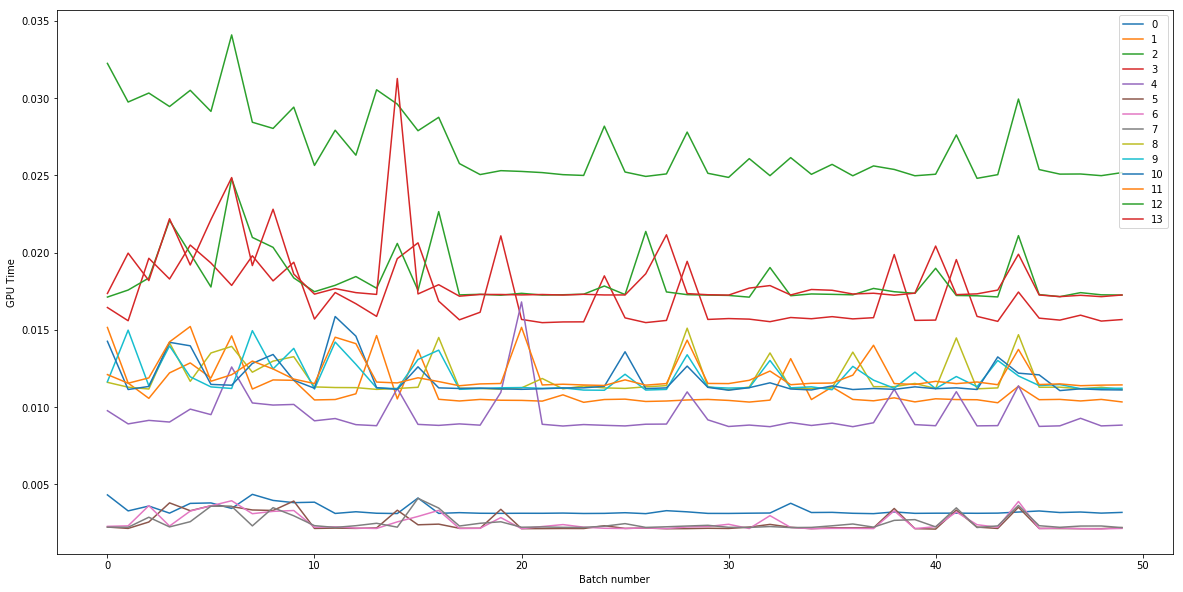

In [75]:
profiler = Profiler(mnv2.model, f"mnv2 {device.type}, expand ratio {expand_ratio}")
a = torch.randn((4, 3, 128, 128))
for _ in range(50):
    profiler.forward(a)
profiler.collect_data()
profiler.show_table()
print(macs_v2, params_v2)
profiler.plot_results()

In [85]:
inverted_residual_setting = [
    # t, c,  n, s, p, d
    [1, 16, 1, 1, 1, 1],
    
    [6, 24, 1, 2, 1, 1],
    [6, 24, 1, 1, 1, 1],

    [6, 32, 1, 2, 1, 1],
    [6, 32, 1, 1, 1, 1],
    [6, 32, 1, 1, 1, 1],
    
    [6, 64, 1, 1, 2, 2],
    [6, 64, 1, 1, 1, 1],
    [6, 64, 1, 1, 1, 1],
    [6, 64, 1, 1, 1, 1],
    
    [6, 96, 1, 1, 1, 1],
    [6, 96, 1, 1, 1, 1],
    [6, 96, 1, 1, 1, 1],
]

expand_ratio = 1

for l in inverted_residual_setting[1:]:
    l[0] = expand_ratio
    
    
inverted_residual_setting

[[1, 16, 1, 1, 1, 1],
 [1, 24, 1, 2, 1, 1],
 [1, 24, 1, 1, 1, 1],
 [1, 32, 1, 2, 1, 1],
 [1, 32, 1, 1, 1, 1],
 [1, 32, 1, 1, 1, 1],
 [1, 64, 1, 1, 2, 2],
 [1, 64, 1, 1, 1, 1],
 [1, 64, 1, 1, 1, 1],
 [1, 64, 1, 1, 1, 1],
 [1, 96, 1, 1, 1, 1],
 [1, 96, 1, 1, 1, 1],
 [1, 96, 1, 1, 1, 1]]

In [86]:
mnv2 = MobileNetV2(in_channels = 32, last_channels = 320, inverted_residual_setting = inverted_residual_setting)
net = PoseEstimationWithMobileNet(backbone = mnv2.model, after_backbone_channels = 96)

mnv2 (whole net) cpu, expand ratio 1
+---------------------+----------+---------+------------+
|         Name        | Mean, ms | Std, ms | Percent, % |
+---------------------+----------+---------+------------+
|        model        |  31.16   |   3.51  |   39.21    |
|         cpm         |   7.41   |   2.01  |    9.32    |
|    initial_stage    |  12.45   |   2.55  |   15.66    |
| refinement_stages 0 |  28.46   |   5.57  |   35.81    |
+---------------------+----------+---------+------------+
Total time: 79.48 ms, 	std: 10.22 ms


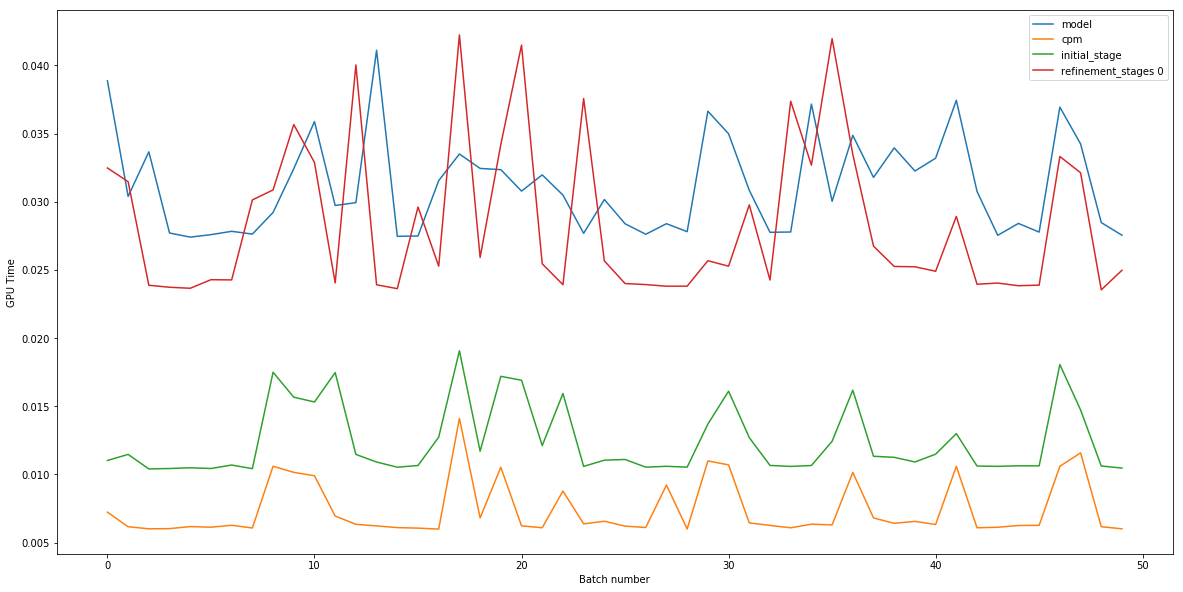

In [87]:
profiler = Profiler(net, f"mnv2 (whole net) {device.type}, expand ratio {expand_ratio}")
a = torch.randn((4, 3, 128, 128))
for _ in range(50):
    profiler.forward(a)
profiler.collect_data()
profiler.show_table()
profiler.plot_results()